### Generate figures for Steve's Grant

In [ ]:
import itertools
import os 
import string
import h5py as h5
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.io as io
import scipy.signal as ss 
from scipy.ndimage.filters import gaussian_filter1d
import torch
import sys

sys.path.append('/home/melander/first_mouse_deep_retina/torch-deep-retina/models/')
sys.path.append('/home/melander/first_mouse_deep_retina/torch-deep-retina/utils/')




# STATIC VARIABLES
PD_THRESHOLD = 200
MEA_SAMPLERATE = 10000
FLIP_RATE = 30.00127321


# PATH STRINGS



# This is a bit of magic to make matplotlib figures appear inline in the
# notebook rather than in a new window.
%matplotlib inline
plt.rcParams['figure.figsize'] = (20.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams["axes.labelsize"] = 40
plt.rcParams["ytick.labelsize"] = 40
plt.rcParams["xtick.labelsize"] = 40

path_to_h5 = '/home/melander/first_mouse_deep_retina/data/JBMmr002/JBMmr002.h5'
txt_dir = '/home/melander/first_mouse_deep_retina/spike_times/JBMmr002/'
path_to_stim = '/home/melander/first_mouse_deep_retina/stimulus_files/JBMms002/JBMms002.h5'
path_to_training_file = '/home/melander/first_mouse_deep_retina/naturalmovie_with_test2.h5'


# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [19]:
DEVICE = torch.device("cuda:0")
torch.cuda.empty_cache()

In [20]:
!CUDA_VISIBLE_DEVICES==1

In [28]:
# load the losses

losses = []
for i in range(100):
    try:
        
        file = "/home/melander/first_mouse_deep_retina/torch-deep-retina/training_scripts/checkpoints/lok_epoch_{0}.pth".format(i)
        with open(file, "rb") as fd:
            temp = torch.load(fd)
        losses.append(temp['loss'])
    except:
        pass




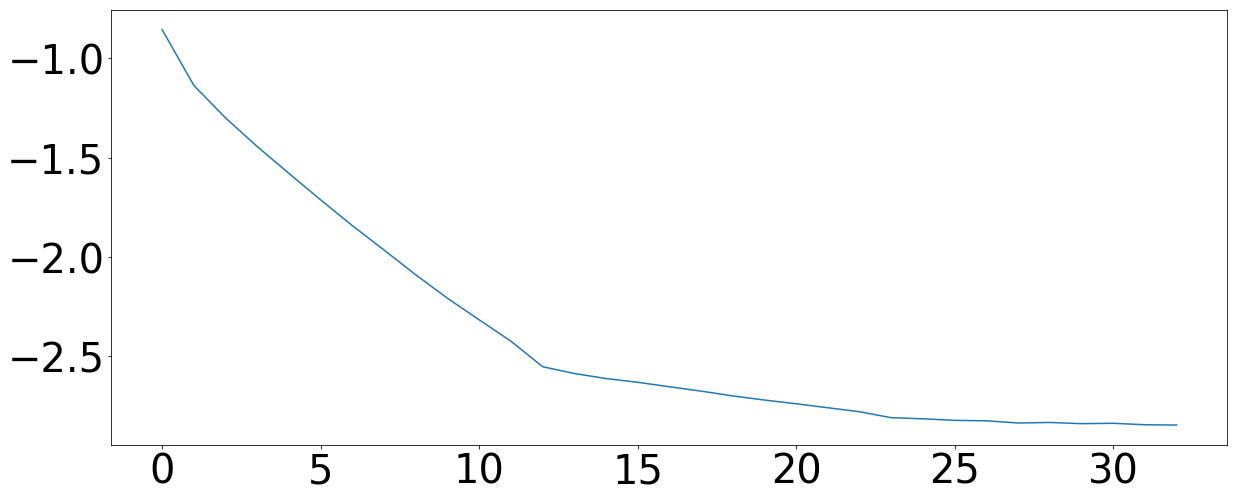

In [29]:
plt.plot(losses)

In [30]:
bn_cnn = temp['model']

In [31]:
bn_cnn = bn_cnn.to(DEVICE)
bn_cnn.eval()

BNCNN(
  (conv1): Conv2d(40, 8, kernel_size=(15, 15), stride=(1, 1))
  (batch1): BatchNorm1d(10368, eps=0.001, momentum=0.99, affine=True, track_running_stats=True)
  (conv2): Conv2d(8, 8, kernel_size=(11, 11), stride=(1, 1))
  (batch2): BatchNorm1d(5408, eps=0.001, momentum=0.99, affine=True, track_running_stats=True)
  (linear): Linear(in_features=5408, out_features=2, bias=False)
  (batch3): BatchNorm1d(2, eps=0.001, momentum=0.99, affine=True, track_running_stats=True)
)

In [36]:
import physiology
import retinal_phenomena as rp
physio = physiology.Physio(bn_cnn)

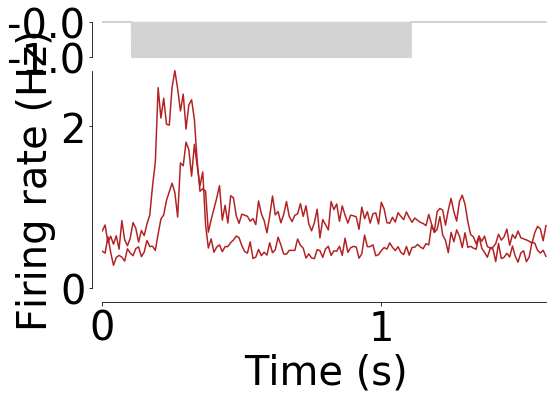

In [37]:
figs, X, resp= rp.step_response(bn_cnn)

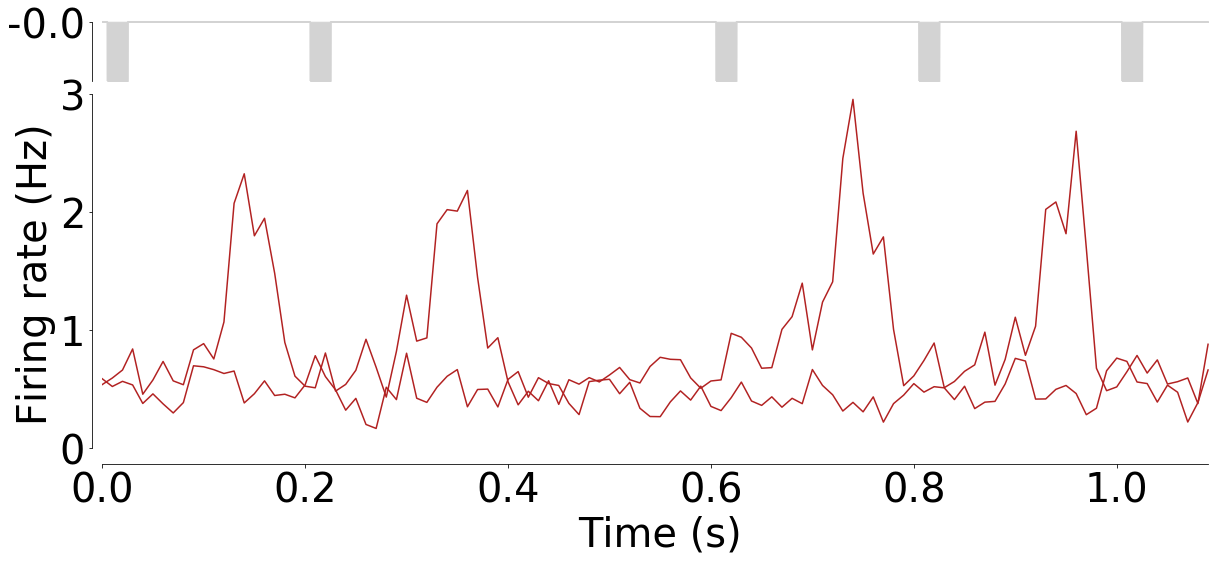

In [38]:
figs, X, resp = rp.osr(bn_cnn)


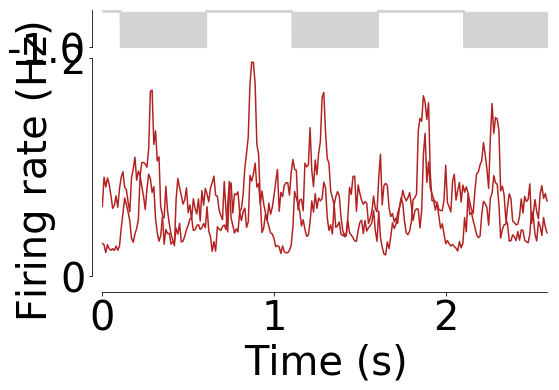

In [39]:
figs, X, resp = rp.reversing_grating(bn_cnn)

51it [00:00, 69.53it/s]


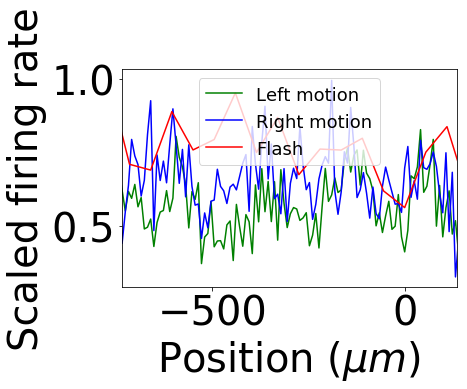

In [40]:
(fig, ax), (speed_left, speed_right), (c_right, stim_right, resp_right), (c_left, stim_left, resp_left), (flash_centers, flash_responses) = rp.motion_anticipation(bn_cnn,velocity=.15)

In [41]:
# Load raw data
f = h5.File(path_to_h5)
data = f['data'].value

In [53]:
pd = data[0]
pd_peaks = ss.find_peaks(gaussian_filter1d(pd,sigma=3),height=1200)
pd_peaks = np.asarray(pd_peaks[0])
np.diff(pd_peaks)[0:80]

# Find correct experiment times
expt_times = []
CUTOFF = 1000
for i in np.arange(len(pd_peaks)-1):
    if (pd_peaks[i+1] - pd_peaks[i])>CUTOFF:
        expt_times.append(pd_peaks[i])

expt_times = np.asarray(expt_times).T

np.diff(expt_times)/MEA_SAMPLERATE    




array([ 600.099 ,   60.0966,   60.0965, 2100.1797,   60.0632,  600.0823,
         60.0965, 2100.163 ,   60.0632,  600.0823,   60.1132])

In [56]:
f_stim = h5.File(path_to_stim)

OSError: Unable to create file (unable to open file: name = '/home/melander/first_mouse_deep_retina/stimulus_files/JBMms002/JBMms002.h5', errno = 17, error message = 'File exists', flags = 15, o_flags = c2)

In [55]:
fs = sorted(os.listdir(txt_dir))
fs = [f for f in fs if f.endswith(".txt")]
cells = []
for a in fs:
    text_file = open(txt_dir + a, "r")
    spikes = text_file.read().split('\n')
    cells.append([float(spike) for spike in spikes if (not (not spike)) and float(spike) > 0])
    
    text_file.close()


num_cells = len(np.asarray(cells))
experiments = []
left_peaks = expt_times
left_peaks = left_peaks - left_peaks[0]
num_frames = []
for j in np.arange(len(left_peaks)-1):
    val = f_stim['expt%i/stim' % (j+1)].value.shape[0]
    num_frames.append(val)
    

for fi in np.arange(len(left_peaks))[:-1]:
    cur_val = left_peaks[fi]/MEA_SAMPLERATE
    next_val = (cur_val + num_frames[fi]/FLIP_RATE)
    single_experiment = []
    for ci in np.arange(num_cells):
        cur_cell = np.asarray(cells[ci])
        a = np.where(cur_cell >= cur_val)
        b = np.where(cur_cell <= next_val)
        spike_indx = np.intersect1d(a,b)
        d = cur_cell[spike_indx]
        single_experiment.append(d)
        del(a,b,d,spike_indx)
        
    experiments.append(single_experiment)
    print("Experiment %d: %d sec" % (fi,(next_val-cur_val)))

NameError: name 'f_stim' is not defined